In [1]:
%%writefile ImageSegmentation.py
import os
import argparse

# ARGS
parser = argparse.ArgumentParser()
parser.add_argument("--num_epochs", type=int, help="number of epochs")
parser.add_argument("--learning_rate", type=float, help="learning_rate")
parser.add_argument("--image_size", type=int, help="image_size")
parser.add_argument("--checkpoint_path", type=str, help="checkpoint_path")
parser.add_argument("--batch_size", type=int, help="batch_size")
parser.add_argument("--num_classes", type=int, help="num_classes")
parser.add_argument("--image_path", type=str, help="image_path")
parser.add_argument("--mask_path", type=str, help="mask_path")
parser.add_argument("--buffer_size", type=int, help="buffer_size")
args = parser.parse_args()


num_epochs=args.num_epochs
buffer_size = args.buffer_size
batch_size = args.batch_size
checkpoint_path=args.checkpoint_path
image_path = args.image_path
mask_path = args.mask_path
image_size=args.image_size
image_shape = (image_size, image_size)

# UTILS
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

def read_data_from_dir(image_path, mask_path, image_shape):
    

    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    image_list = [image_path+i for i in image_list]
    mask_list = [mask_path+i for i in mask_list]

    image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
    mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)


    return tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))



def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, image_shape, method='nearest')
    input_mask = tf.image.resize(mask, image_shape, method='nearest')

    return input_image, input_mask

def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    
    ds_size=len(list(dataset.as_numpy_iterator()))
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)    
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds



# MODEL

# conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection


# upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size=3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 kernel_size=3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

# unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)

    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    

    ublock6 = upsampling_block(cblock5[0], cblock4[1] ,  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

def main():
    
    # data 
    raw_dataset =  read_data_from_dir(image_path, mask_path, image_shape)
    image_ds = raw_dataset.map(process_path)
    dataset = image_ds.map(preprocess)


    unet = unet_model(image_shape +(3,) )

    unet.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    train_dataset, val_dataset, test_dataset =get_dataset_partitions_tf(dataset, # dataset
                                                                        train_split=0.8,
                                                                        val_split=0.1, 
                                                                        test_split=0.1)  

    train_dataset = train_dataset.cache().shuffle(buffer_size).batch(batch_size)
    val_dataset = val_dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    
    model_history = unet.fit(train_dataset, 
                             epochs=num_epochs,
                             validation_data=val_dataset,
                             callbacks=[cp_callback]
                            )

if __name__=="__main__":
    main()
    
    


Overwriting ImageSegmentation.py


In [2]:
!python ImageSegmentation.py --num_epochs=5 --batch_size=32 --image_path="data/CameraRGB/" \
                             --mask_path="data/CameraMask/" --buffer_size=500 \
                             --image_size=160 --checkpoint_path="model/cp.ckpt" --num_classes=23


2023-03-11 21:45:42.130021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 21:45:45.631131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1195 - accuracy: 0.1509
Epoch 1: saving model to model/cp.ckpt
1/1 [==============================] - 5s 5s/step - loss: 3.1195 - accuracy: 0.1509 - val_loss: 2.7464 - val_accuracy: 0.3382
Epoch 2/5
1/1 [==============================] - ETA: 0s - l


# INFERENCE

In [3]:
%%writefile InferenceForImageSeg.py
import os
import argparse

# ARGS
parser = argparse.ArgumentParser()
parser.add_argument("--image_size", type=int, help="image_size")
parser.add_argument("--checkpoint_path", type=str, help="checkpoint_path")
parser.add_argument("--batch_size", type=int, help="batch_size")
parser.add_argument("--num_classes", type=int, help="num_classes")
parser.add_argument("--image_path", type=str, help="image_path")
parser.add_argument("--mask_path", type=str, help="mask_path")


args = parser.parse_args()

batch_size = args.batch_size
checkpoint_path=args.checkpoint_path
image_path = args.image_path
mask_path = args.mask_path
image_size=args.image_size
image_shape = (image_size, image_size)



#checkpoint_path="model/cp.ckpt"
#image_path="data/CameraRGB/"
#mask_path="data/CameraMask/"



import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate




def read_data_from_dir(image_path, mask_path, image_shape): 

    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    
    image_list = [image_path+i for i in image_list]
    mask_list = [mask_path+i for i in mask_list]

    image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
    mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)


    return tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))



def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (160, 160), method='nearest')
    input_mask = tf.image.resize(mask, (160, 160), method='nearest')

    return input_image, input_mask

def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    
    ds_size=len(list(dataset.as_numpy_iterator()))
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)    
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


def display(display_list, fig_name):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        #plt.savefig("")
        plt.savefig(str(fig_name)+".png")
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]



# MODEL

# conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection


# upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size=3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 kernel_size=3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

# unet_model
def unet_model(input_size=(160, 160, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)

    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    

    ublock6 = upsampling_block(cblock5[0], cblock4[1] ,  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


def main():
    
    image_shape=(160, 160)
    
    model =unet_model(image_shape +(3,) )
    model.load_weights(checkpoint_path)
    
    # I have ot fix some about shape in process functions
    raw_dataset =  read_data_from_dir(image_path, mask_path, image_shape)
    image_ds = raw_dataset.map(process_path)
    dataset = image_ds.map(preprocess)
    _, _, test_dataset =get_dataset_partitions_tf(dataset, # dataset
                                                  train_split=0.8,
                                                  val_split=0.1, 
                                                  test_split=0.1) 
    n=0
    for image, mask in test_dataset.take(5):
        sample_image, sample_mask = image, mask
        n=n+1
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))], "image_mask_pred_"+str(n))
        #need to save the plots
        print("Done")
        
        
if __name__=="__main__":
    main()
    

Overwriting InferenceForImageSeg.py


In [4]:
!python InferenceForImageSeg.py --image_path="data/CameraRGB/" \
                             --mask_path="data/CameraMask/" \
                             --image_size=160 --checkpoint_path="model/cp.ckpt"

2023-03-11 21:46:10.220702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 21:46:13.613859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 0s 229ms/step
Figure(1500x1500)
Done
1/1 [==============================] - 0s 57ms/step
Figure(1500x1500)
Done
1/1 [==============================] - 0s 58ms/step
Figure(1500x1500)
Done


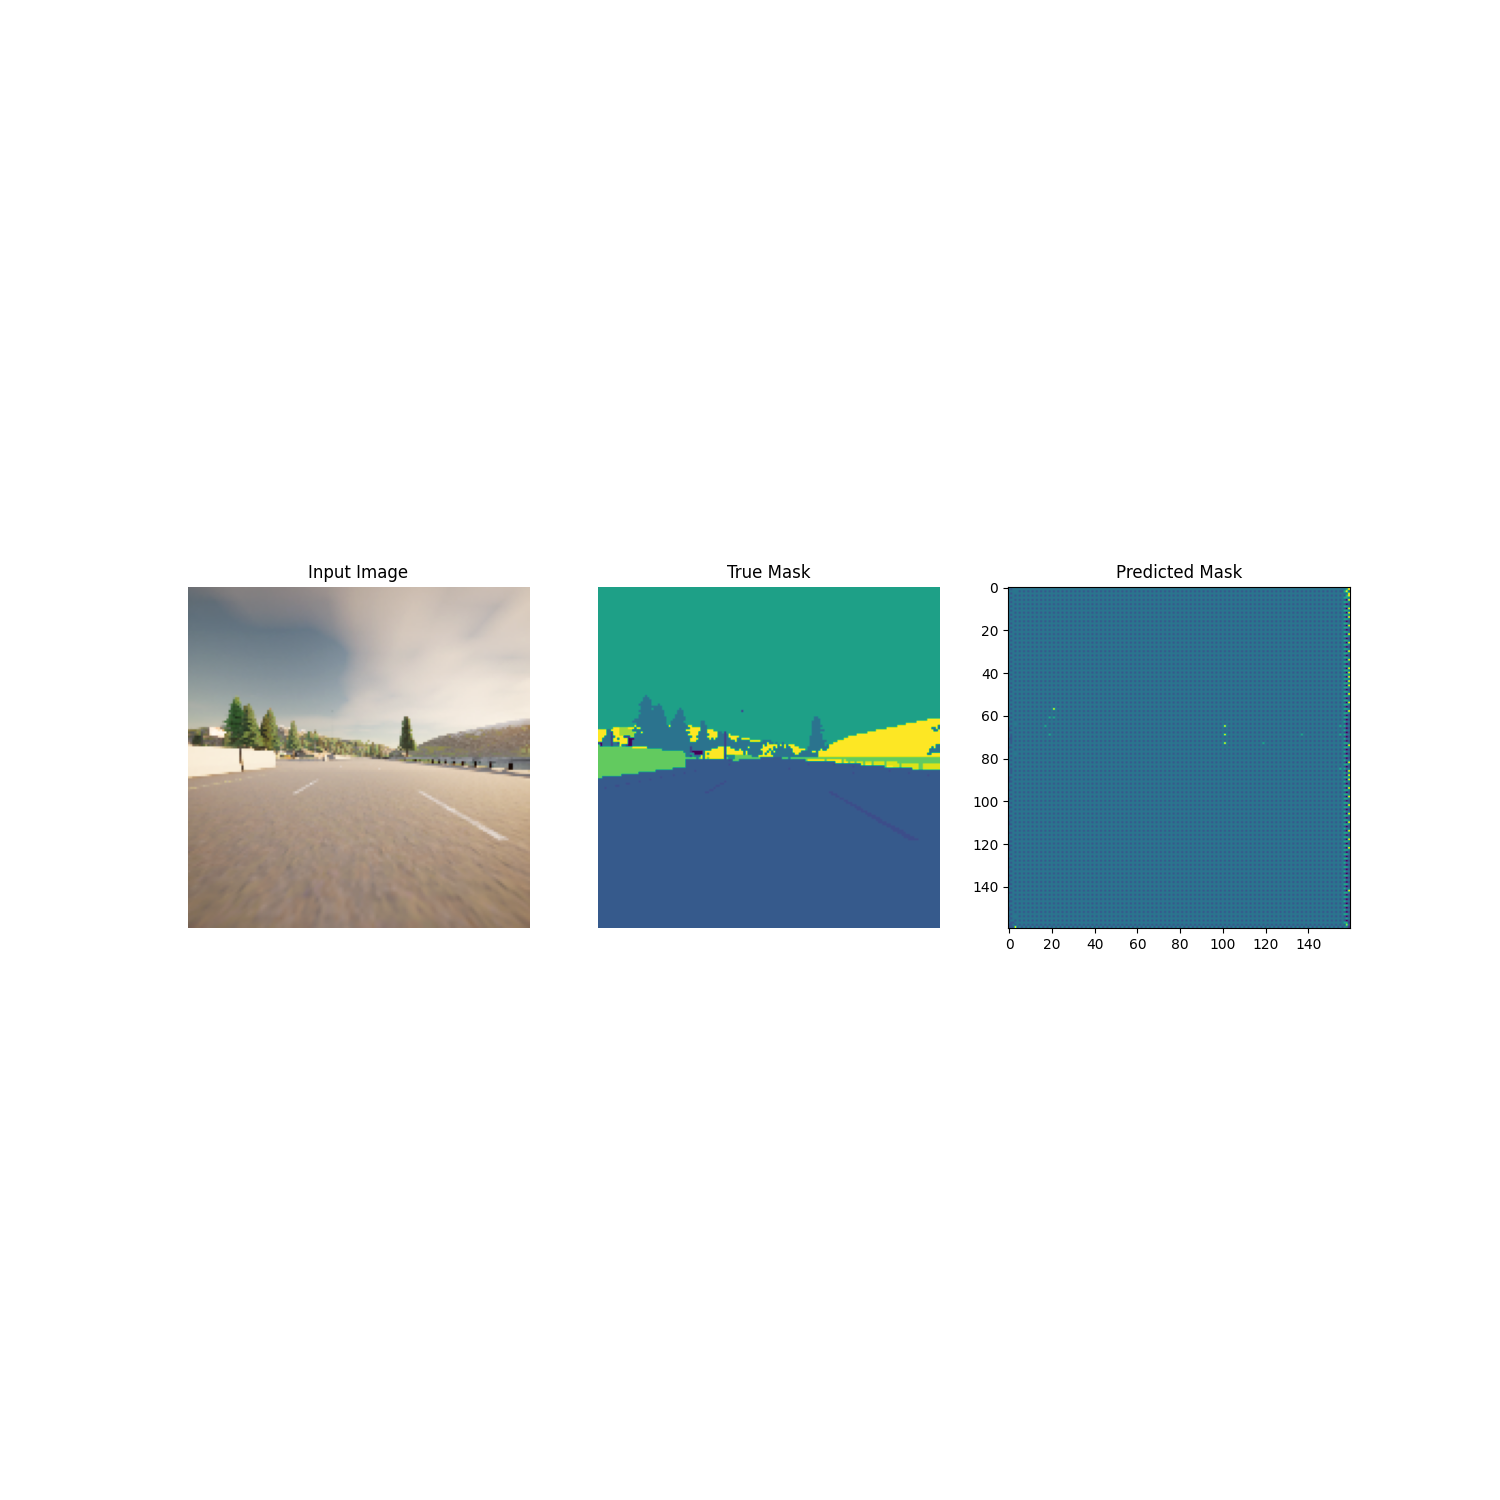

In [5]:
import imageio
from PIL import Image
import numpy as np
#imageio.imread("image_mask_pred_1.png")
Image.open("image_mask_pred_3.png")
